In [1]:
from openai import OpenAI
import numpy as np
import cv2
from PIL import Image
import base64
from io import BytesIO

client = OpenAI(api_key="EMPTY",
                base_url="http://10.15.89.71:34134/v1/",
                timeout=3600)



In [2]:
# 辅助函数：将图像编码为 base64
def encode_image_to_base64(image_rgb):
    """将 RGB numpy 数组转换为 base64 编码的字符串"""
    pil_image = Image.fromarray(image_rgb.astype('uint8'), 'RGB')
    buffered = BytesIO()
    pil_image.save(buffered, format="PNG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode('utf-8')
    return f"data:image/png;base64,{img_base64}"


In [3]:
# 加载真实的标记好的导航图像
image_path = "/home/liujy/mobile_manipulation/model_server/logs/run_20260115_225756/iter_0001_rgb_vis.jpg"
annotated_image = cv2.imread(image_path)
annotated_image = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)  # 转换为 RGB

print("加载了标记图像，尺寸:", annotated_image.shape)
print("图像路径:", image_path)


加载了标记图像，尺寸: (540, 960, 3)
图像路径: /home/liujy/mobile_manipulation/model_server/logs/run_20260115_225756/iter_0001_rgb_vis.jpg


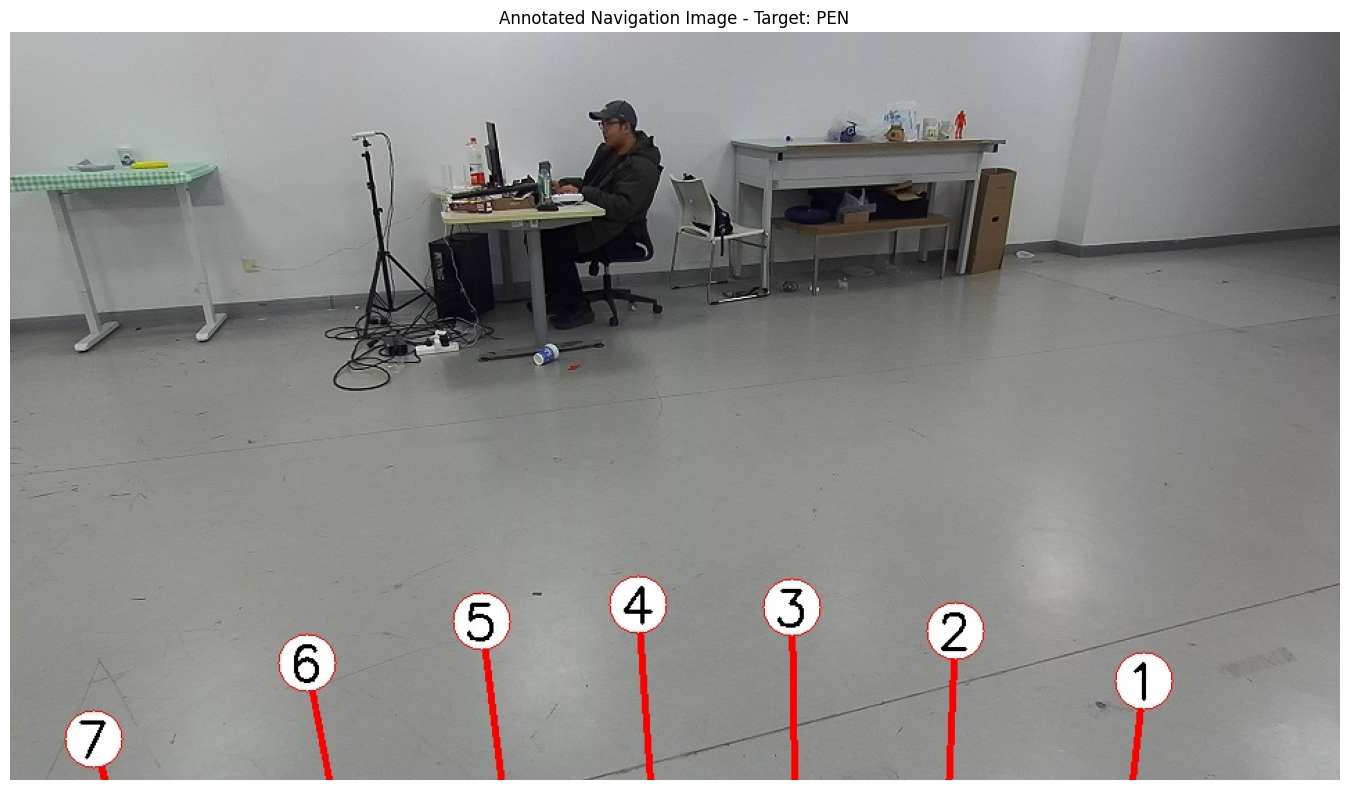

In [4]:
# 显示标注后的图像
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 8))
plt.imshow(annotated_image)
plt.title("Annotated Navigation Image - Target: PEN")
plt.axis('off')
plt.tight_layout()
plt.show()


In [5]:
# 构建导航 prompt（基于 nav_agent.py 的 _construct_prompt 方法）
goal = "banana"
num_actions = 7  # 从图像中可以看到有 7 个标记的动作

# 构建 prompt（简化版，不包含历史记录）
prompt = f"""TASK: NAVIGATE TO THE NEAREST {goal.upper()}, and get as close to it as possible. 
Use your prior knowledge about where items are typically located within a room. 
The robot uses an omnidirectional (omni-wheel) base and can rotate in place with a very small turning radius. 

There are {num_actions} red arrows superimposed onto your CURRENT observation, which represent potential MOVE actions. 
These MOVE actions are labeled with a NON-ZERO number in a white circle, which represent the location you would move to if you took that action. 
Think step by step internally, but do not output reasoning. Only return the action as {{'action': <action_key>}}

NOTE: action 0 is NOT shown in this image but means TURN AROUND (rotate 180° in place) and is NOT a move-to-waypoint action. 
There is NO waypoint 0. The red-arrow move actions are ONLY the non-zero numbered actions (1-{num_actions}). 

SEARCH RULE: If you do not see the target and have no strong lead, do NOT turn around immediately. 
First choose a safe MOVE action that reveals NEW space/viewpoints (e.g., open area, action at the image edges). 

First of all, chose a safe direction to go to, consider the body of the robot itself. 
If you want to check somewhere(a desk, an open area, etc.), you may not need to go there directly, which may cause collision, you can move to a place near it and then turn to check it. 
If you think you have checked a place, you should go to the next place to check, do not stay in one place too long. 
If you want to go to a place far away, you should explore nearby first(by choosing an action at the image edges to turn to new spots). 
Avoid to go the way near to the wall or obstacle. Avoid to turn too early during forward navigation; turning around is only for search when needed. 

First, think about what you see in your sensor observation, and if you have any leads on finding the {goal.upper()}. 
Second, think about which general direction you should go in. 
Lastly, think about which action acheives that best. 
Note you CANNOT GO THROUGH CLOSED DOORS, and you DO NOT NEED TO GO UP OR DOWN STAIRS"""

print("构建的 Prompt:")
print("-" * 80)
print(prompt)
print("-" * 80)


构建的 Prompt:
--------------------------------------------------------------------------------
TASK: NAVIGATE TO THE NEAREST BANANA, and get as close to it as possible. 
Use your prior knowledge about where items are typically located within a room. 
The robot uses an omnidirectional (omni-wheel) base and can rotate in place with a very small turning radius. 

There are 7 red arrows superimposed onto your CURRENT observation, which represent potential MOVE actions. 
These MOVE actions are labeled with a NON-ZERO number in a white circle, which represent the location you would move to if you took that action. 
Think step by step internally, but do not output reasoning. Only return the action as {'action': <action_key>}

NOTE: action 0 is NOT shown in this image but means TURN AROUND (rotate 180° in place) and is NOT a move-to-waypoint action. 
There is NO waypoint 0. The red-arrow move actions are ONLY the non-zero numbered actions (1-7). 

SEARCH RULE: If you do not see the target and ha

In [10]:
# 使用本地部署的 Qwen8B 进行推理
import time

# 将图像编码为 base64
image_url = encode_image_to_base64(annotated_image)

# 构建消息
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "text",
                "text": prompt
            },
            {
                "type": "image_url",
                "image_url": {
                    "url": image_url
                }
            }
        ]
    }
]

print("\n发送请求到 Qwen8B...")
print(f"图像尺寸: {annotated_image.shape}")
print(f"Prompt 长度: {len(prompt)} 字符")

# 记录开始时间
start_time = time.time()

# 调用 Qwen8B
try:
    response = client.chat.completions.create(
        model="/data/sea_disk0/liujy/models/Qwen/Qwen3-VL-8B-Instruct/",
        messages=messages,
        max_tokens=128,
        temperature=0.0
    )
    
    # 记录结束时间
    end_time = time.time()
    inference_time = end_time - start_time
    
    # 提取响应内容
    response_text = response.choices[0].message.content
    
    print(f"\n推理时间: {inference_time:.2f} 秒")
    print("\n" + "="*80)
    print("Qwen8B 响应:")
    print("="*80)
    print(response_text)
    print("="*80)
    
except Exception as e:
    print(f"\n错误: {e}")
    print(f"错误类型: {type(e).__name__}")



发送请求到 Qwen8B...
图像尺寸: (540, 960, 3)
Prompt 长度: 2060 字符

推理时间: 0.21 秒

Qwen8B 响应:
{'action': 1}
